In this notebook, I'm going to be exploring the `Student_Performance` dataset. I'm going to try to make models to analyze the relationships within the data, as well as make predictions with the given information.

In [2]:
# load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
# load dataset
df = pd.read_csv("Student_Performance.csv")
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


In [5]:
# encode string variable
df['Extracurricular Activities'] = df['Extracurricular Activities'].apply(lambda x: 1 if x=='Yes' else 0)
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


All features have a roughly uniform distribution, except `Performance Index` which had a rough Normal distribution, as seen below:

<Axes: xlabel='Performance Index', ylabel='Count'>

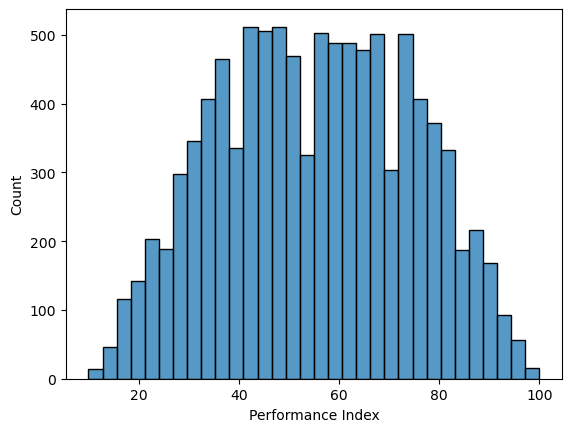

In [7]:
sns.histplot(x=df['Performance Index'])

No features had any outliers, statistical or otherwise.

I found the following relationships, with the plots shown below:
1. `Hours Studied` and `Performance Index` seem positively linearly related
2. `Previous Scores` and `Performance Index` are very strongly positively linearly related
3. Students participating in `Extracurricular Activities` had less `Sleep Hours`

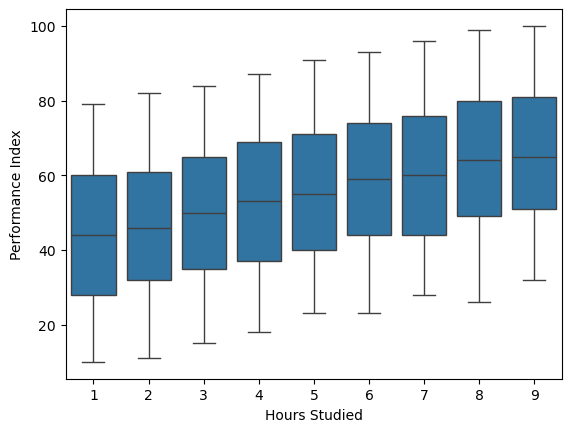

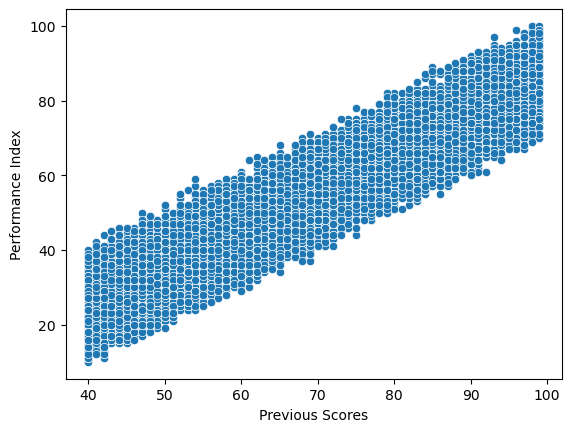

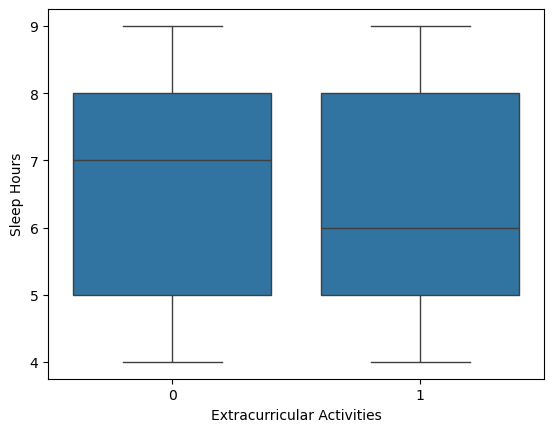

In [10]:
sns.boxplot(x=df['Hours Studied'], y=df['Performance Index'])
plt.show()

sns.scatterplot(x=df['Previous Scores'], y=df['Performance Index'])
plt.show()

sns.boxplot(x=df['Extracurricular Activities'], y=df['Sleep Hours'])
plt.show()

All the relationships are quite self-explanatory. I was expecting `Hours Studied` to be related to `Extracurricular Activities` as well as `Sleep Hours`, but surprisingly there was none.

Now, I'm going to build a linear regression model, so that we can get a numerical understanding of the data.

In [13]:
# split train and test sets
X = df.loc[:,['Hours Studied', 'Previous Scores']]
y = df[['Performance Index']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# build linear regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [15]:
# evaluate model
model_lr.score(X_test, y_test)

0.9859445764337783

An R-squared value of ~0.99 means that almost ALL of the variance in `Performance Index` is explained by the variance in `Hours Studied` and `Previous Scores`. This is unsurprising, as the plots from above show that `Performance Index` is VERY strongly related to both these variables.

In [17]:
model_lr.coef_

array([[2.86449217, 1.01615225]])

Here's what the coefficients tell us:
1. `Performance Index` increases by ~2.86 as `Hours Studied` increases by 1
2. `Performance Index` increases by ~1 as `Previous Scores` increases by 1

Interestingly, `Hours Studied` had a greater impact on `Performance Index` compared to `Previous Scores`. This means that even if a student wasn't doing so well before, it was more important that they studied now, for this assessment.

Now, I'd like to train a neural network (NN) for this regression problem. I'd like to see if it can perform any better than the linear regression model. My guess is that in this scenario, with the dataset being relatively large with such strong, direct relationships, the 2 models won't perform too differently.

In [20]:
# define the NN
model_nn = tf.keras.Sequential([
    tf.keras.layers.Dense(units=2, input_shape=(2,)), # input layer and dense layer
    tf.keras.layers.Dense(units=1) # output layer
])

model_nn.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

In [21]:
# train the NN
history = model_nn.fit(X_train, y_train, epochs=100, verbose=False)

Text(0, 0.5, 'MSE')

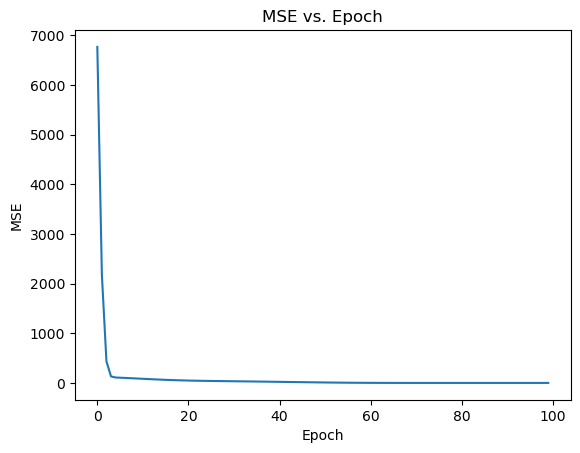

In [22]:
# plot the change in MSE vs. Epoch
sns.lineplot(x=np.arange(100), y=history.history['loss'])
plt.title('MSE vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [23]:
# MSE at last epoch
history.history['loss'][-1]

5.305362701416016

In [24]:
# evaluate the model
model_nn.evaluate(X_test, y_test)

94/94 [==============================] - 0s 1ms/step - loss: 5.1962


5.196182727813721

After training for 100 epochs, the MSE stopped improving at ~5.3 with the test MSE being about the same. This means that on average, a prediction by the model will be ~2.3 (RMSE) away from the actual value (so the model might predict an 87 or 88 while the real value might be 85). This seems like a pretty good model. Let's now calculate the RMSE for the linear regression model so that we can compare the two.

In [26]:
# save the model
model_nn.save('model', overwrite=True)

INFO:tensorflow:Assets written to: model\assets


In [27]:
preds = model_lr.predict(X_test)
se = (preds - y_test)**2
mse = np.mean(se)
rmse = np.sqrt(mse)
rmse

2.2806459919574738

The RMSE for the linear regression model is also ~2.3, which means that the 2 models perform roughly the same. Again, if the real score is an 85, either model might predict an 87 or 88. Overall, both models are quite good.